In [17]:
import numpy as np
import cv2
import pandas as pd
import os
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
# Load your data - modify this based on your data structure
base_path = '/kaggle/input/face-ete/face_data/face_data'
labels_file_path = '/kaggle/input/face-ete/labels.csv'

# Load labels from CSV
df = pd.read_csv(labels_file_path)

In [19]:
df

,image_name,gender,height,weight
0,0001.jpg,1,158.75,52
1,0002.jpg,1,158.75,52
2,0003.jpg,1,158.75,52
3,0004.jpg,1,158.75,52
4,0005.jpg,1,158.75,52
...,...,...,...,...
8995,8996.jpg,1,157.48,62
8996,8997.jpg,1,157.48,62
8997,8998.jpg,1,157.48,62
8998,8999.jpg,1,157.48,62


In [20]:
# Assuming image_name includes the file extension, like "example.jpg"
def load_and_preprocess_image(image_name, label, target_size=(128, 128)):
    image_path = image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image, label

In [21]:
# Load image paths and labels
X_paths = df['image_name'].apply(lambda x: os.path.join(base_path, x)).values
Y = df[['gender', 'height', 'weight']].values

# Load and preprocess the images
data = [load_and_preprocess_image(image_path, label) for image_path, label in zip(X_paths, Y)]

# Separate images and labels
X_data = np.array([item[0] for item in data], dtype=np.float32)
Y_data = np.array([item[1] for item in data], dtype=np.float32)

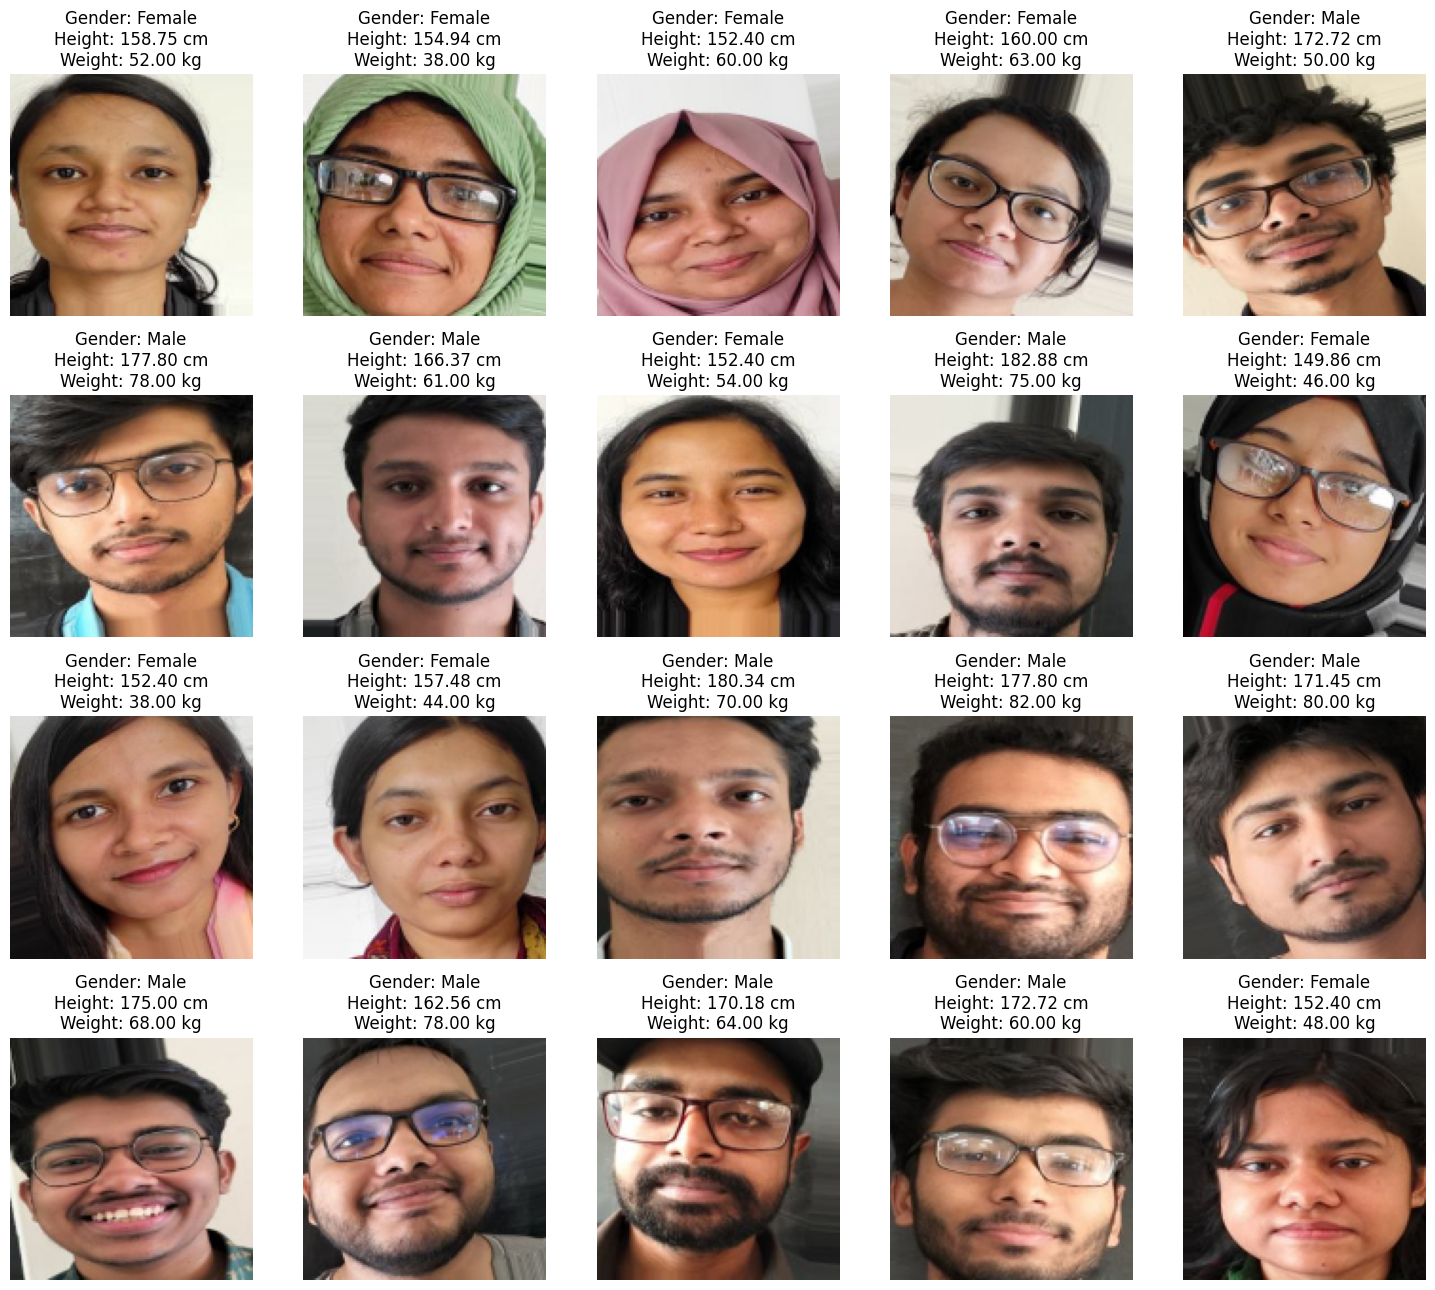

In [47]:
# Visualization code
# Starting index and the gap between images
start_index = 0
gap = 200
num_images_to_visualize = 20

# Calculate the number of rows and columns for a better layout
num_rows = 4
num_cols = 5

# Visualize the specified images with labels
plt.figure(figsize=(15, 13))
for i in range(num_images_to_visualize):
    index = start_index + i * gap
    gender_label = "Male" if Y_data[index][0] == 0 else "Female"
    height_label = f"Height: {Y_data[index][1]:.2f} cm"
    weight_label = f"Weight: {Y_data[index][2]:.2f} kg"
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_data[index])
    plt.title(f"Gender: {gender_label}\n{height_label}\n{weight_label}")
    plt.axis('off')

# Add space between subplots vertically
plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.show()


In [22]:
# Split the data into training, validation, and test sets with a 70-15-15 split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 6300
Validation set size: 1350
Test set size: 1350


Proposed Model

In [34]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define the input shape
input_shape = (128, 128, 3)

# Input layer
input_layer = Input(shape=input_shape)

# Convolutional layers with batch normalization and max pooling
x = Conv2D(64, (3, 3))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)


# Flatten layer
x = Flatten()(x)

# Dense layers with dropout
x = Dense(2048)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)  # Adjusted dropout rate

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)  # Adjusted dropout rate

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.01)(x)  # Adjusted dropout rate

x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.01)(x)  # Adjusted dropout rate


combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=combined_output)


# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

Epoch 1/200
  5/197 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.0403 - loss: 77.7022 - mape: 95.9747 - rmse: 104.0430 

W0000 00:00:1710580841.756649     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1786 - loss: 76.1176 - mape: 82.1391 - rmse: 102.4644

W0000 00:00:1710580860.320058     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710580861.940906     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


197/197 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.1790 - loss: 76.1087 - mape: 82.1021 - rmse: 102.4549 - val_accuracy: 0.2783 - val_loss: 74.5413 - val_mape: 72.1734 - val_rmse: 100.6172
Epoch 2/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.3760 - loss: 68.6541 - mape: 62.3985 - rmse: 94.4412 - val_accuracy: 0.4820 - val_loss: 60.2418 - val_mape: 51.7963 - val_rmse: 85.4482
Epoch 3/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.4785 - loss: 59.2393 - mape: 52.1464 - rmse: 84.3896 - val_accuracy: 0.5801 - val_loss: 50.8481 - val_mape: 41.9927 - val_rmse: 75.5762
Epoch 4/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5992 - loss: 47.9362 - mape: 40.0820 - rmse: 72.5289 - val_accuracy: 0.6164 - val_loss: 45.6302 - val_mape: 38.3601 - val_rmse: 69.2717
Epoch 5/200
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6945 - loss: 37.3101 - mape: 30.5455 - rmse: 59.7445 - val_accuracy: 0.6890 - val_loss: 35.4783 - val_mape: 31.1037 - val_rm

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9850 - loss: 0.4674 - mape: 1.5018 - rmse: 0.8700
27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1710582437.820896     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Gender Test MAE: 0.03884186088762902
Height Test MAE: 0.728331206597223
Weight Test MAE: 0.6035077271638093
Gender Test MAPE: 3.197253819141123
Height Test MAPE: 0.43336216592219245
Weight Test MAPE: 0.9071555468279624
Gender Test RMSE: 0.058453664101647956
Height Test RMSE: 1.0165690876091178
Weight Test RMSE: 1.1641631066975988
Gender Test Accuracy: 0.9680274618085888
Height Test Accuracy: 0.9956663783407781
Weight Test Accuracy: 0.9909284445317204


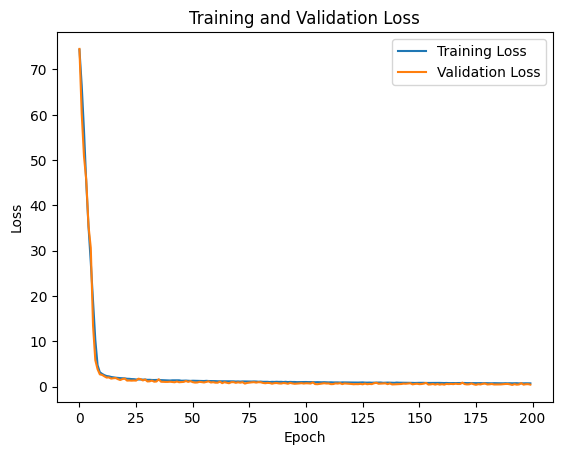

In [36]:
import matplotlib.pyplot as plt

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot_custom_model1.jpg', format='jpg', dpi=600)  # Save the plot as a JPG file
plt.show()

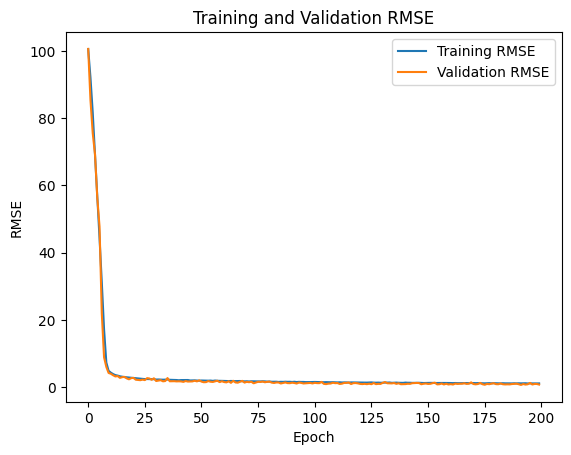

In [37]:
# Plot training RMSE and validation RMSE
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('rmse_plot_custom_model1.jpg', format='jpg',dpi=600)  # Save the plot as a JPG file
plt.show()

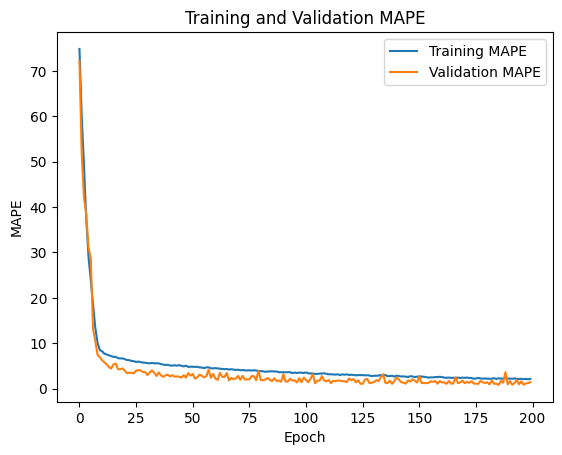

In [38]:
# Plot training MAPE and validation MAPE
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Training and Validation MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.savefig('mape_plot_custom_model1.jpg', format='jpg',dpi=600)  # Save the plot as a JPG file
plt.show()

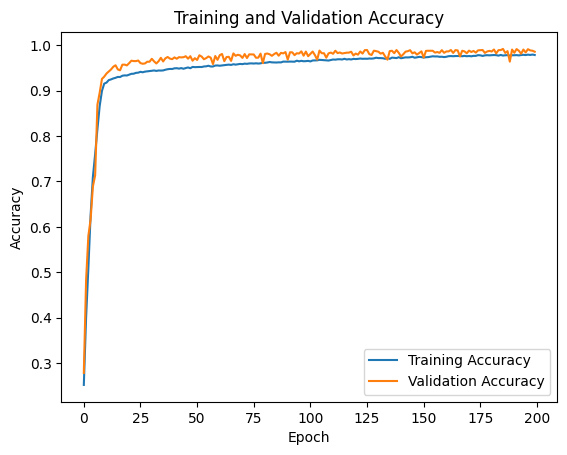

In [39]:
# Plot training Accuracy and validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot_custom_model1.jpg', format='jpg',dpi=600)  # Save the plot as a JPG file
plt.show()

Sample 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
  Original - Gender: Male, Height: 177.80 cm, Weight: 78.00 kg, BMR: 1781.25 calories
  Predicted - Gender: Male, Height: 177.68 cm, Weight: 77.62 kg, BMR: 1776.74 calories



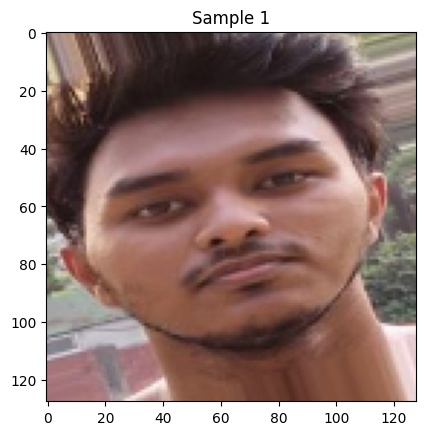

Sample 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
  Original - Gender: Female, Height: 154.94 cm, Weight: 48.00 kg, BMR: 1172.38 calories
  Predicted - Gender: Female, Height: 155.77 cm, Weight: 48.70 kg, BMR: 1184.53 calories



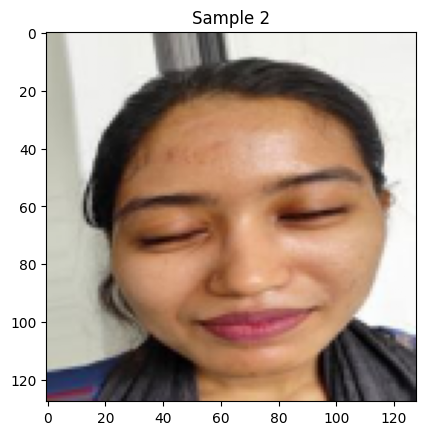

Sample 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Original - Gender: Male, Height: 177.80 cm, Weight: 62.00 kg, BMR: 1621.25 calories
  Predicted - Gender: Male, Height: 174.50 cm, Weight: 63.66 kg, BMR: 1617.24 calories



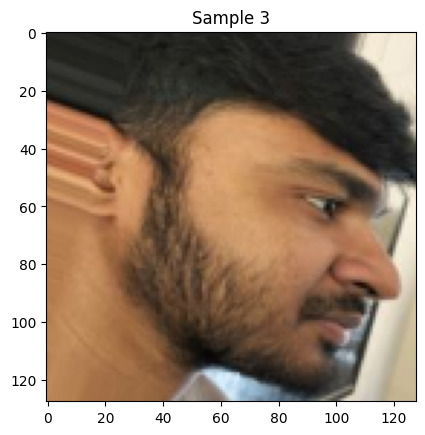

Sample 4:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
  Original - Gender: Male, Height: 171.45 cm, Weight: 50.00 kg, BMR: 1461.56 calories
  Predicted - Gender: Male, Height: 172.02 cm, Weight: 50.54 kg, BMR: 1470.57 calories



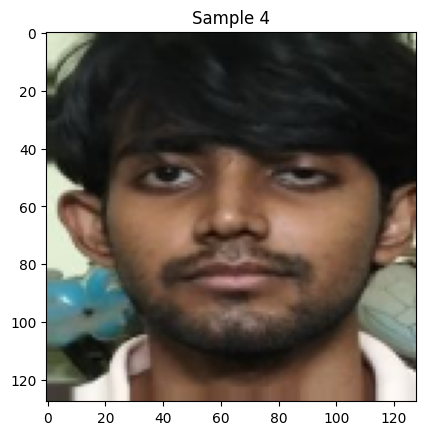

Sample 5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Original - Gender: Female, Height: 157.48 cm, Weight: 44.00 kg, BMR: 1148.25 calories
  Predicted - Gender: Female, Height: 157.39 cm, Weight: 43.99 kg, BMR: 1147.55 calories



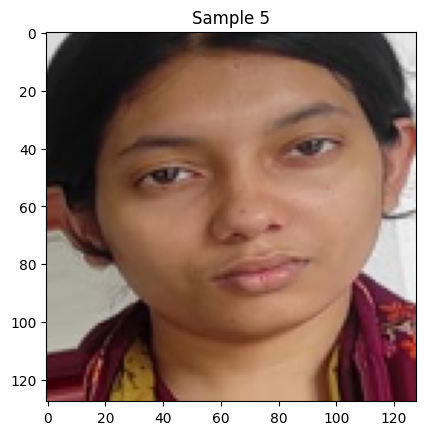

In [40]:
import numpy as np
import cv2
import pandas as pd
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the calculate_bmr function
def calculate_bmr(gender_prob, weight, height, age):
    gender = 0 if gender_prob < 0.5 else 1
    if gender == 0:  # Assuming 0 represents Male
        bmr = 10 * weight + 6.25 * height - 5 * age + 5
    elif gender == 1:  # Assuming 1 represents Female
        bmr = 10 * weight + 6.25 * height - 5 * age - 161
    else:
        raise ValueError("Invalid gender value. Use 0 for Male, 1 for Female.")
    return bmr

# Lists to store original and predicted BMR, gender, height, and weight values
original_values_list = []
predicted_values_list = []

# Fixed age for calculation
age_for_calculation = 23

# Display original and predicted values for BMR, gender, height, and weight
for i in range(5):  # Adjust the number based on your preference
    print(f"Sample {i + 1}:")

    # Original values
    original_gender = "Male" if Y_test[i, 0] == 0 else "Female"
    original_height = Y_test[i, 1]
    original_weight = Y_test[i, 2]
    original_bmr = calculate_bmr(Y_test[i, 0], original_weight, original_height, age_for_calculation)

    original_values_list.append({
        'Gender': original_gender,
        'Height': original_height,
        'Weight': original_weight,
        'BMR': original_bmr
    })

    # Predicted values from your model
    predictions = model.predict(np.expand_dims(X_test[i], axis=0))
    predicted_gender_prob = predictions[0, 0]
    predicted_gender = "Male" if predicted_gender_prob < 0.5 else "Female"
    predicted_height = predictions[0, 1]
    predicted_weight = predictions[0, 2]

    # Calculate predicted BMR using predicted gender probability, height, weight, and fixed age
    predicted_bmr = calculate_bmr(predicted_gender_prob, predicted_weight, predicted_height, age_for_calculation)

    predicted_values_list.append({
        'Gender': predicted_gender,
        'Height': predicted_height,
        'Weight': predicted_weight,
        'BMR': predicted_bmr
    })

    # Display original and predicted values
    print(f"  Original - Gender: {original_gender}, Height: {original_height:.2f} cm, Weight: {original_weight:.2f} kg, BMR: {original_bmr:.2f} calories")
    print(f"  Predicted - Gender: {predicted_gender}, Height: {predicted_height:.2f} cm, Weight: {predicted_weight:.2f} kg, BMR: {predicted_bmr:.2f} calories")
    print()

    # Display the image
    plt.imshow(X_test[i])
    plt.title(f"Sample {i + 1}")
    plt.show()
